In [1]:
#%% Imports
import os
import shutil
import nibabel as nib
import numpy as np
import random
from glob import glob
from scipy import ndimage
from nilearn.image import resample_to_img, resample_img
from nilearn.masking import compute_background_mask, compute_epi_mask
from nilearn.plotting import plot_roi, plot_epi

In [2]:
# Set working directory
os.chdir('/home/uziel/DISS')

In [3]:
# load prediction
root = './milestones_1/DM_V1_transfer_0/output/predictions/trainSession/predictions'
root_2 = './data/ISLES2017/training'

segms = sorted(glob(os.path.join(root, '*Segm.nii.gz')))
prob_maps_class0 = sorted(glob(os.path.join(root, '*ProbMapClass0.nii.gz')))
prob_maps_class1 = sorted(glob(os.path.join(root, '*ProbMapClass1.nii.gz')))
segms_img = []

# resize its prediction for final result validation
for i in range(len(segms)):
    # Find subject that contains the code in pred.
    subject = sorted([y
                      for x in os.walk(root_2)
                      for y in glob(os.path.join(x[0], '*'))
                      if segms[i].split('_')[-2] in y
                     ])[0].split('/')[-2]
    
    subject_channels = sorted([y
                               for x in os.walk(os.path.join(root_2, subject))
                               for y in glob(os.path.join(x[0], '*MR_*.nii'))
                               if '4DPWI' not in y
                              ])
    
    original_img = nib.load(subject_channels[0])
    
    # load prediction
    pred = nib.load(segms[i])
    pmap_0 = nib.load(prob_maps_class0[i])
    pmap_1 = nib.load(prob_maps_class1[i])
    
    # Upsample to original size
    pred = resample_img(pred,
                        original_img.affine,
                        original_img.shape,
                        interpolation='nearest')
    pmap_0 = resample_img(pmap_0,
                          original_img.affine,
                          original_img.shape,
                          interpolation='continuous')
    pmap_1 = resample_img(pmap_1,
                          original_img.affine,
                          original_img.shape,
                          interpolation='continuous')

    segms_img.append([subject_channels, pred, pmap_0, pmap_1])   

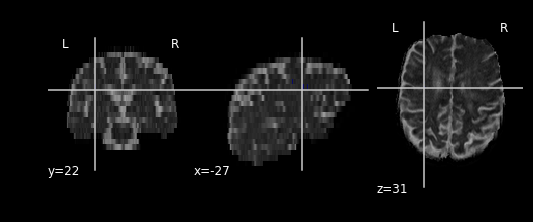

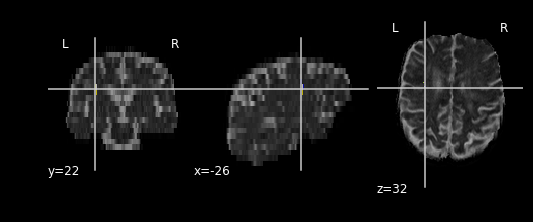

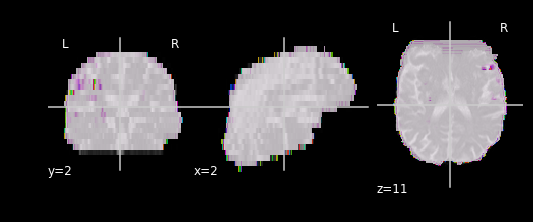

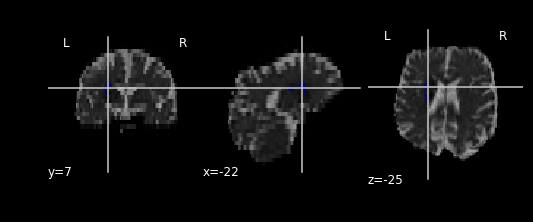

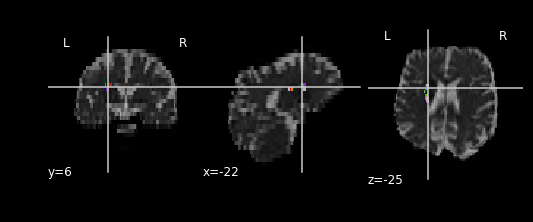

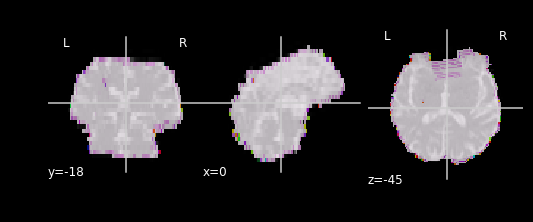

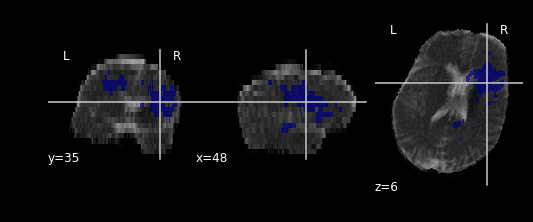

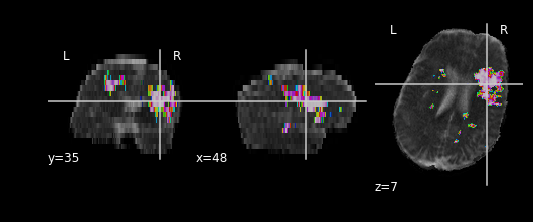

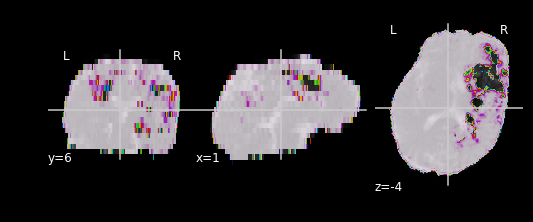

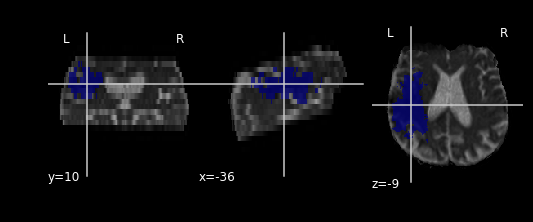

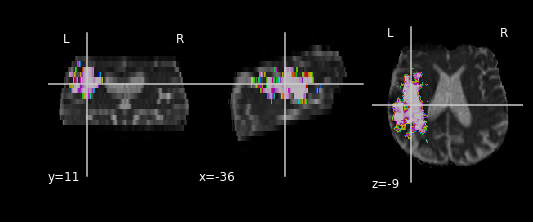

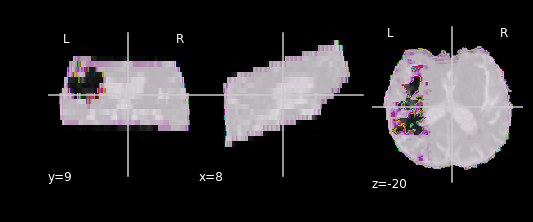

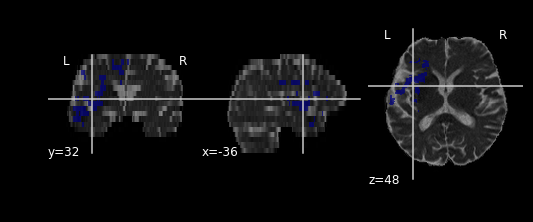

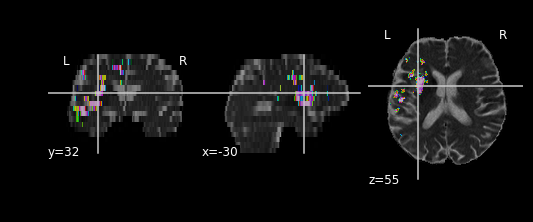

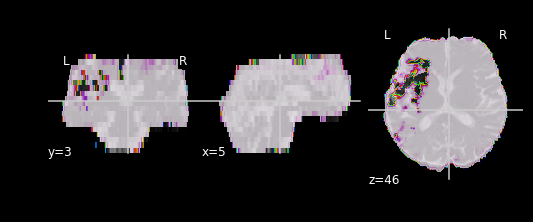

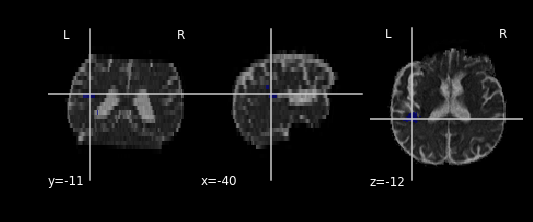

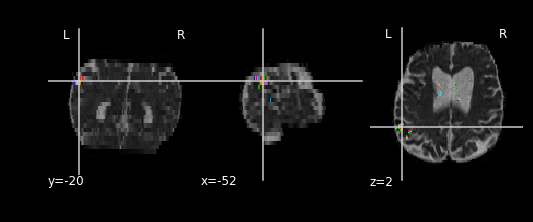

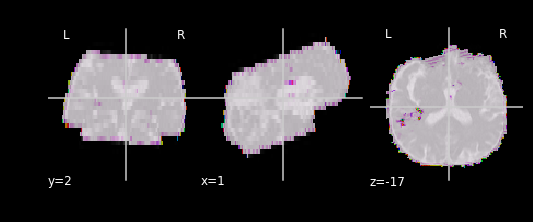

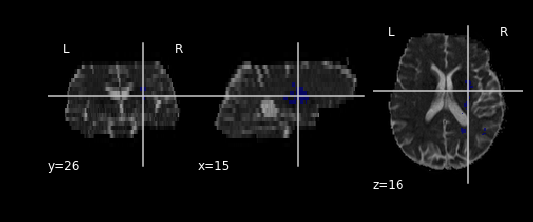

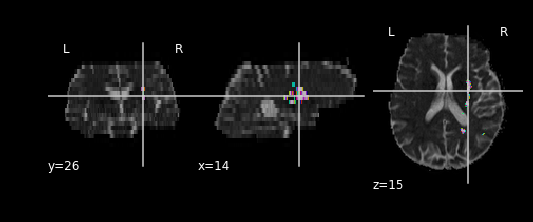

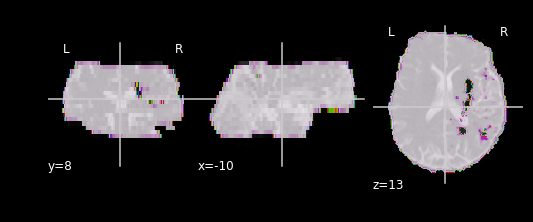

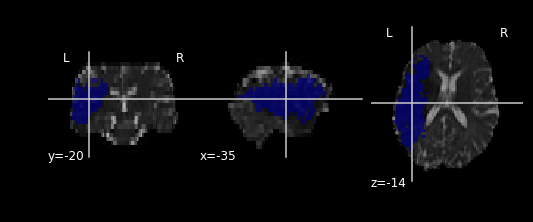

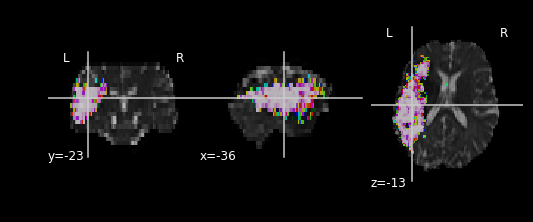

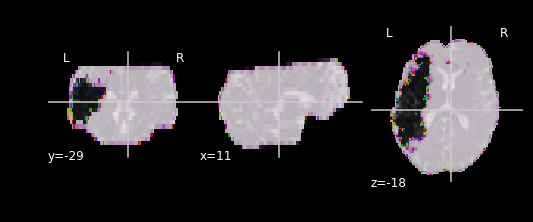

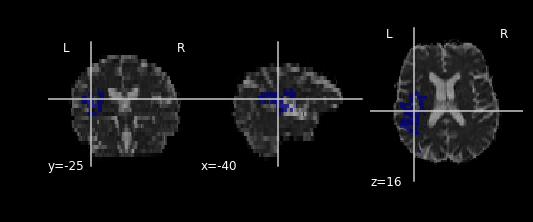

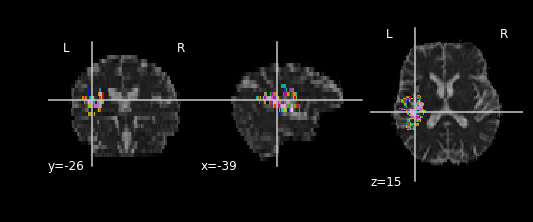

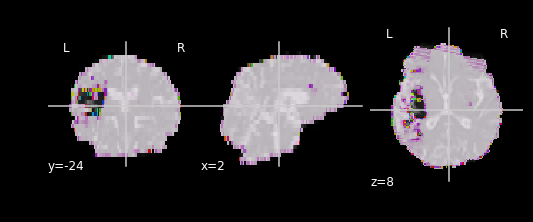

In [5]:
for subject_channels, pred, pmap_0, pmap_1 in segms_img:
    original_img = nib.load(subject_channels[0])
    plot_roi(pred, original_img)
    plot_roi(pmap_1, original_img)
    plot_roi(pmap_0, original_img)